# Comparing the outputs of `pythonradex` and `RADEX`

This notebook aims to provide a simple example of how to compare the excitation temperatures, optical depths and brightness temperatures calculated by `pythonradex` and `RADEX`.

## Preparation

First, some preparation work is needed in order to use `RADEX`. Proceed as follows:
1. Download `RADEX` from the [official RADEX page](https://sronpersonalpages.nl/~vdtak/radex/index.shtml) and install it according to the instructions. Make sure to choose "uniform sphere" as the geometry for the escape probability in `radex.inc`, as we will use that geometry in this example.
2. Download the file `RADEX_wrapper.py` from [here](https://github.com/gica3618/pythonradex/tree/master/docs/notebooks) and place it into the same folder as this notebook. In that file, modify the `radex_path` to point to your `RADEX` executable.

## Single model

Run a single model with `RADEX` and `pythonradex`, and compare the outputs. Here we consider CO as an example.

In [1]:
from pythonradex import helpers,radiative_transfer
from scipy import constants
import os
import matplotlib.pyplot as plt
import numpy as np
import RADEX_wrapper

In [2]:
#define here the path to the folder that contains your LAMDA-formatted files
data_folder = "/home/gianni/science/LAMDA_database_files"

In [3]:
datafilename = "co.dat"
collider_densities = {"ortho-H2":5e4*constants.centi**-3}
#assume thermal ortho/para ratio:
collider_densities["para-H2"] = collider_densities["ortho-H2"]/3
Tkin = 50
T_background = 2.73
N = 1e16*constants.centi**-2
width_v = 2.3*constants.kilo
#be careful with modifying the geometry. If you change the geometry for pythonradex,
#you also need to re-compile RADEX with the new geometry
#Also be careful when comparing to other geometries;
#- LVG sphere: RADEX and pythonradex use different escape probability (but you could use "LVG sphere RADEX")
#- static slab: not supported by RADEX
#- LVG slab: pythonradex only supports rectangular line profile
geometry = "static sphere"
#RADEX makes calculations using a rectangular profile, but it uses a correction factor to convert flux and optical
#depth to Gaussian, so choosing Gaussian is the appropriate choice for comparison with pythonradex
line_profile_type = "Gaussian"

In [4]:
source = radiative_transfer.Source(
                datafilepath=os.path.join(data_folder,datafilename),
                geometry=geometry,line_profile_type=line_profile_type,
                width_v=width_v)
def ext_background(nu):
    return helpers.B_nu(T=T_background,nu=nu)
source.update_parameters(ext_background=ext_background,N=N,Tkin=Tkin,
                        collider_densities=collider_densities,
                        T_dust=0,tau_dust=0)
source.solve_radiative_transfer()

In [5]:
#now run RADEX
radex_result = RADEX_wrapper.run(datafilename=datafilename,collider_densities=collider_densities,
                                 Tkin=Tkin,T_background=T_background,N=N,width_v=width_v,
                                 input_filepath="test.inp",output_filepath="test.out")

Let's compare excitation temperatures, level populations and optical depths. Note that comparing intensities is not that straightforward, since `RADEX` and `pythonradex` compute intensities differently.

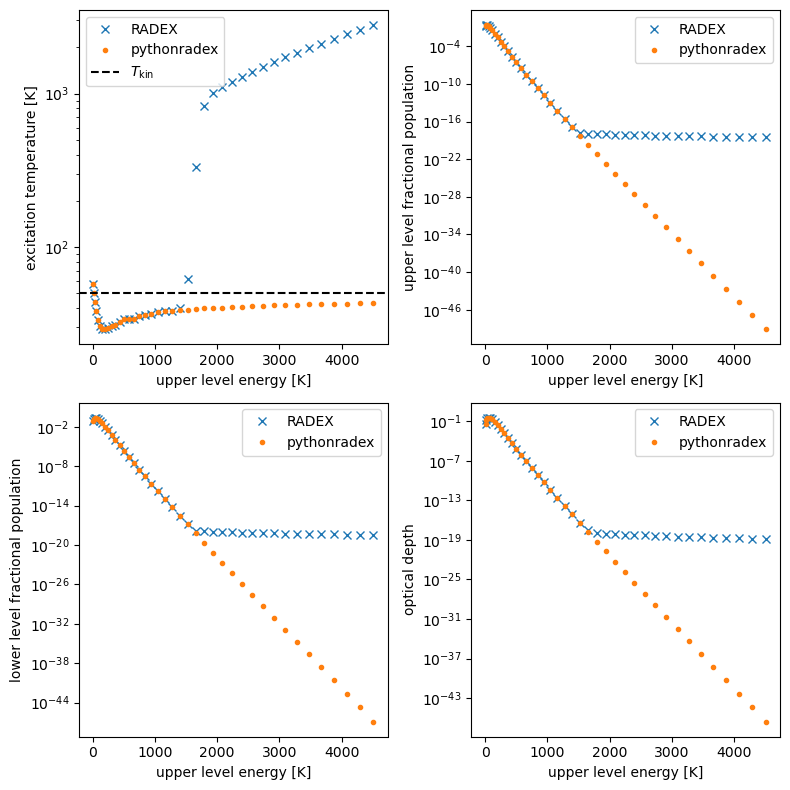

In [6]:
def plot_comparison(source,radex_result,yscale,max_E_up=np.inf):
    E_up = [trans.up.E/constants.k for trans in source.emitting_molecule.rad_transitions]
    E_up = np.array(E_up)
    E_up_selection = E_up < max_E_up
    Tex = {"RADEX":radex_result["Tex"],"pythonradex":source.Tex}
    pop_up = {"RADEX":radex_result["pop_up"],
              "pythonradex":[source.level_pop[t.up.index] for t in source.emitting_molecule.rad_transitions]}
    pop_low = {"RADEX":radex_result["pop_low"],
               "pythonradex":[source.level_pop[t.low.index] for t in source.emitting_molecule.rad_transitions]}
    tau_nu0 = {"RADEX":radex_result["tau"],"pythonradex":source.tau_nu0_individual_transitions}
    comparison_quantities = {"Tex":Tex,"pop_up":pop_up,"pop_low":pop_low,
                             "tau_nu0":tau_nu0}
    y_labels = {"Tex":"excitation temperature [K]","pop_up":"upper level fractional population",
               "pop_low":"lower level fractional population","tau_nu0":"optical depth"}
    fig,axes = plt.subplots(2,2,figsize=(8,8))
    marker = {"RADEX":"x","pythonradex":"."}
    for ax,(quantity_name,quantity) in zip(axes.ravel(),comparison_quantities.items()):
        for code,values in quantity.items():
            ax.plot(E_up[E_up_selection],np.array(values)[E_up_selection],marker[code],label=code)
        if quantity_name == "Tex":
            ax.axhline(Tkin,linestyle="dashed",color="black",label="$T_\mathrm{kin}$")
        ax.set_xlabel("upper level energy [K]")
        ax.set_ylabel(y_labels[quantity_name])
        ax.legend(loc="best")
        ax.set_yscale(yscale)
    fig.tight_layout()

plot_comparison(source=source,radex_result=radex_result,yscale="log")

The agreement is good, except for excitation temperatures of transitions with very high upper level energy. Although the departure between `RADEX` and `pythonradex` looks dramatic for upper level energies exceeding ~1500 K, in practice it does not make a difference. Indeed, the corresponding levels are almost unpopulated (as expected, given that the kinetic temperature is much lower than the upper level energy), and thus the corresponding transitions are extremely weak (i.e. not observable).

Let's make the same plots, but in linear scale and restricting the upper level energies.

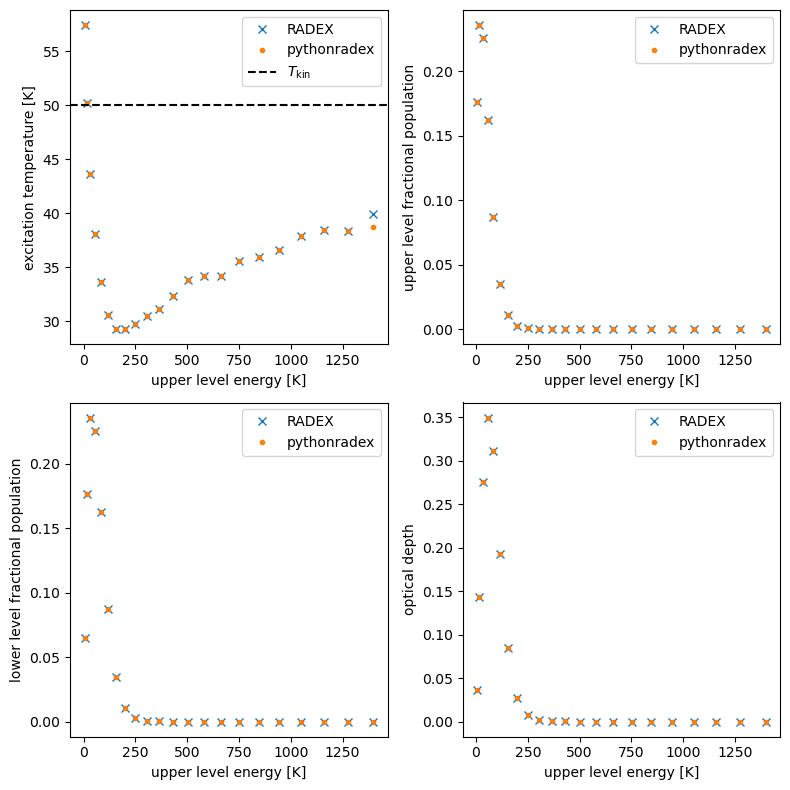

In [7]:
plot_comparison(source=source,radex_result=radex_result,yscale="linear",max_E_up=1500)

### Comparing intensities and brightness temperatures

Comparing intensities, respectively brightness temperatures, is not straightforward mainly for two reasons:
1. `RADEX` calculates background-subtracted intensities, while `pythonradex` just calculates the emission from the source and leaves and background subtraction to the user.
1. For spherical geometries, `RADEX` and `pythonradex` use different formulas to calculate the intensity (see the documentation for more details.

Thus, to compare intensities / brightness temperatures, some additional calculation is necessary. We transform the results from `pythonradex` such that they can be compared to `RADEX`.

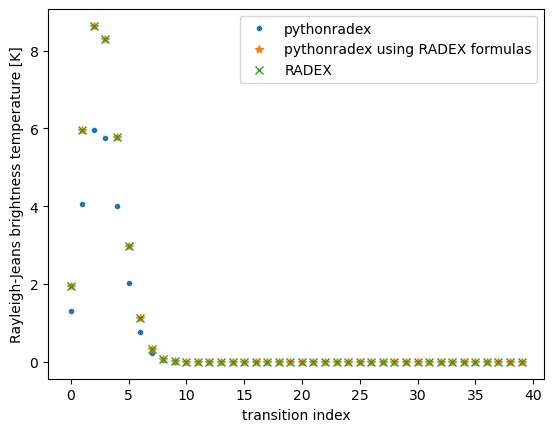

In [8]:
nu0 = source.emitting_molecule.nu0 #all rest frequencies
tau_nu0 = source.tau_nu0_individual_transitions
#use the same formula as RADEX to calculate the specific intensity
specific_intensity_nu0 = helpers.B_nu(nu=nu0,T=source.Tex) * (1-np.exp(-tau_nu0))
#now compute background subtraction
specific_intensity_nu0_bg_subtracted = specific_intensity_nu0 + ext_background(nu0)*np.exp(-tau_nu0) - ext_background(nu0)
#transform to Rayleigh-Jeans brightness temperature
TR_pythonradex_bg_subtracted = helpers.RJ_brightness_temperature(specific_intensity=specific_intensity_nu0_bg_subtracted,nu=nu0)

#for comparison, also plot the RJ temperature computed by pythonradex
TR_pythonradex = source.emission_at_line_center(output_type="Rayleigh-Jeans")

fig,ax = plt.subplots()
ax.plot(TR_pythonradex,marker=".",label="pythonradex",linestyle="")
ax.plot(TR_pythonradex_bg_subtracted,marker="*",label="pythonradex using RADEX formulas",linestyle="")
ax.plot(radex_result["TR"],marker="x",label="RADEX",linestyle="")
ax.set_xlabel("transition index")
ax.set_ylabel("Rayleigh-Jeans brightness temperature [K]")
ax.legend(loc="best")

The agreement is excellent if the same formulas are used.

### Negative excitation temperatures or optical depths

Both `RADEX` and `pythonradex` can produce unreliable results characterised by, for example, negative excitation temperatures. Let's consider some extreme parameters: a column density of $10^{18}$ cm$^{-2}$ and a kinetic temperature of 1500 K.

/home/gianni/science/projects/code/pythonradex_joss/pythonradex/src/pythonradex/radiative_transfer.py:341: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')


1-0: tau_nu0 = -0.0262
2-1: tau_nu0 = -0.0908
3-2: tau_nu0 = -0.202
4-3: tau_nu0 = -0.161


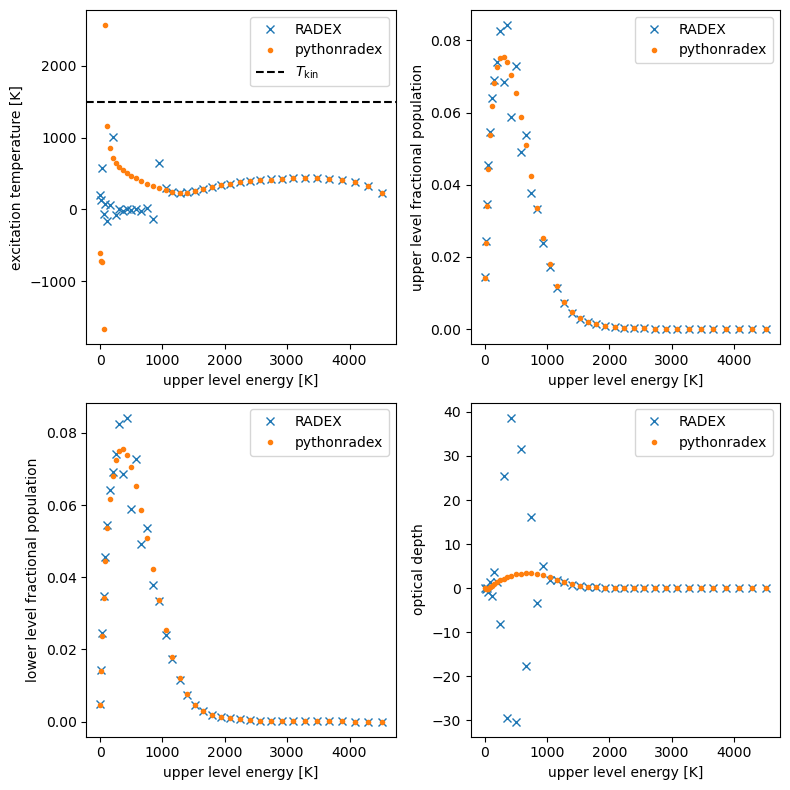

In [9]:
N = 1e18*constants.centi**-2
Tkin = 1500
source.update_parameters(N=N,Tkin=Tkin)
source.solve_radiative_transfer()

radex_result = RADEX_wrapper.run(datafilename=datafilename,collider_densities=collider_densities,
                                 Tkin=Tkin,T_background=T_background,N=N,width_v=width_v,
                                 input_filepath="test.inp",output_filepath="test.out")

plot_comparison(source=source,radex_result=radex_result,yscale="linear")

For this particular example, both `RADEX` and `pythonradex` predict negative excitation temperatures for transitions with low upper energy. Both codes also predict negative optical depth (`RADEX` for more transitions than `pythonradex`). These results are probably not reliable.

## Model grid

Here we compare `RADEX` and `pythonradex` on a model grid. Let's focus on CO 2-1. We calculate the excitation temperature over a grid of H$_2$ density and column density:

In [10]:
H2_grid = np.logspace(3,7,10)*constants.centi**-3
N_grid = np.logspace(13,18,15)*constants.centi**-2

#fix Tkin:
Tkin = 100
source.update_parameters(Tkin=Tkin)
trans_index = 1 #CO 2-1

Tex = {"RADEX":np.empty((H2_grid.size,N_grid.size))}
Tex["pythonradex"] = Tex["RADEX"].copy()

for i,nH2 in enumerate(H2_grid):
    #assume thermal ortho/para ratio
    collider_densities = {"ortho-H2":nH2*3/4,"para-H2":nH2/4}
    for j,N in enumerate(N_grid):
        source.update_parameters(N=N,collider_densities=collider_densities)
        source.solve_radiative_transfer()
        Tex["pythonradex"][i,j] = source.Tex[trans_index]
        radex_result = RADEX_wrapper.run(
                            datafilename=datafilename,collider_densities=collider_densities,
                            Tkin=Tkin,T_background=T_background,N=N,width_v=width_v,
                            input_filepath="grid.inp",output_filepath="grid.out")
        Tex["RADEX"][i,j] = radex_result["Tex"][trans_index]

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


1-0: tau_nu0 = -0.000134
1-0: tau_nu0 = -0.000305
1-0: tau_nu0 = -0.000692
1-0: tau_nu0 = -0.00157


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


1-0: tau_nu0 = -0.00355
1-0: tau_nu0 = -0.00796
1-0: tau_nu0 = -0.0175
1-0: tau_nu0 = -0.0371
1-0: tau_nu0 = -0.0725
1-0: tau_nu0 = -0.122
1-0: tau_nu0 = -0.152
1-0: tau_nu0 = -0.0653
1-0: tau_nu0 = -4.18e-05
1-0: tau_nu0 = -9.5e-05
1-0: tau_nu0 = -0.000216
1-0: tau_nu0 = -0.000491


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


1-0: tau_nu0 = -0.00112
1-0: tau_nu0 = -0.00253
1-0: tau_nu0 = -0.00569
1-0: tau_nu0 = -0.0126
1-0: tau_nu0 = -0.027
1-0: tau_nu0 = -0.0535
1-0: tau_nu0 = -0.0891
1-0: tau_nu0 = -0.0995


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point excep


We first inspect the excitation temperature for each code:

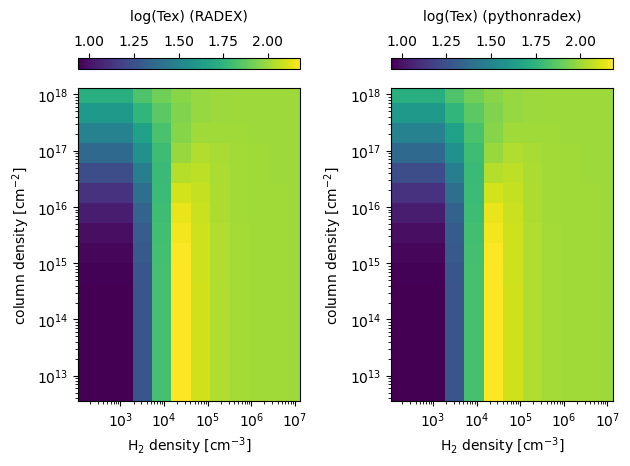

In [11]:
H2_GRID,N_GRID = np.meshgrid(H2_grid,N_grid,indexing="ij")
fig,axes = plt.subplots(ncols=2)
for ax,(code,Tex_values) in zip(axes.ravel(),Tex.items()):
    im = ax.pcolormesh(H2_GRID/constants.centi**-3,N_GRID/constants.centi**-2,np.log10(Tex_values))
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', location='top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.set_label(f"log(Tex) ({code})", labelpad=10)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("H$_2$ density [cm$^{-3}$]")
    ax.set_ylabel("column density [cm$^{-2}$]")
fig.tight_layout()

Looks like both codes produces similar excitation temperatures. Also, both codes correctly reproduce the LTE limit (high H$_2$ density) where the excitation temperature should equal the kinetic temperature.

Let's also look at the ratio to check how large the difference between the two codes is:

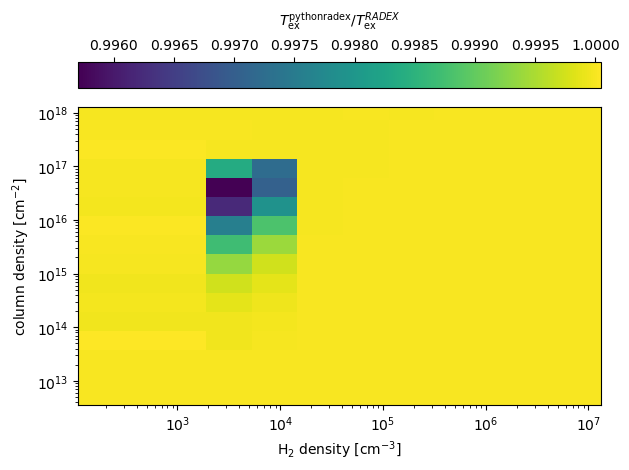

In [12]:
Tex_ratio = Tex["pythonradex"]/Tex["RADEX"]
fig,ax = plt.subplots()
im = ax.pcolormesh(H2_GRID/constants.centi**-3,N_GRID/constants.centi**-2,Tex_ratio)
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', location='top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_ticks_position('top')
cbar.set_label("$T_\mathrm{ex}^\mathrm{pythonradex}/T_\mathrm{ex}^{RADEX}$", labelpad=10)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("H$_2$ density [cm$^{-3}$]")
ax.set_ylabel("column density [cm$^{-2}$]")
fig.tight_layout()

The agreement is extremely good, wich deviations less than 1%.